# A simple classification network

Here we will demonstrate a simple classification network, using iris species as our example.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

Read in data into a Panda DataFrame.

In [2]:
df = pd.read_csv('./data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Plot the data

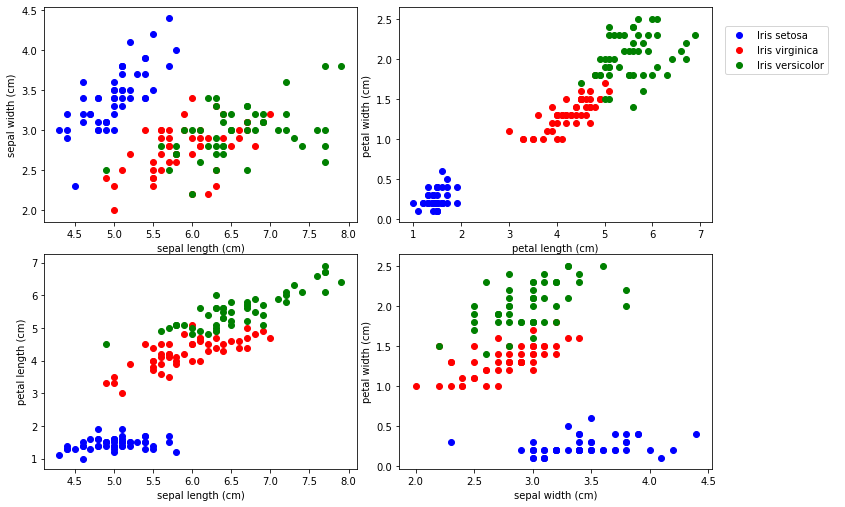

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(
            df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Perform Train/Test Split

In this example we will use a single train/test split. In practice it is common to use multiple train/test splits, often with k-fold validation (where every data point is present in one, and only one, test set).

In [4]:
# X data is all data apart from 'target'
X = df.drop('target',axis=1).values
# y data is 'target'
y = df['target'].values

# Use sklearns train_test_split method to divide data
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42)

## Scale feature data

For neural networks it is most common to use MinMax scaling to scale all data to range 0-1.
Training and test X data are scaled according to min and max in training data.

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [6]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

## Use PyTorch DataLoader to batch training data

In [7]:
# Set up train data as a TensorDataSet
train_data = \
    TensorDataset(torch.FloatTensor(X_train_sc),torch.LongTensor(y_train))

# Note: use of shuffle here will shuffle the data between training epochs
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Convert X/y to Tensors
X_train_tensor = torch.FloatTensor(X_train_sc)
X_test_tensor = torch.FloatTensor(X_test_sc)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

## Set up network

In [8]:
# Base model on PyTorch nn.Module class
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        # Inherit parent (nn.module) methods using super init
        super().__init__()
        # Define layers
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        # Pass data through net. Use relu activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        x = F.softmax(x, dim=-1) # Probability normalisation
        return x

In [9]:
# Create model
model = Model()
# Set loss 
criterion = nn.CrossEntropyLoss()
# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train the model

In [10]:
# epochs = number of times to pass over training data
epochs = 100

# Set up lists for loss and accuracy
train_accuracy = []
test_accuracy = []
train_losses = []
test_losses = []

# Loop through required number of epochs
for epoch in range(epochs):
    # Train model (using batches): Switch to training mode
    model.train()
    for batch in train_loader:
        y_pred = model.forward(batch[0])
        loss = criterion(y_pred, batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Get results for complete training set: Switch to evaluation mode
    model.eval()
    y_pred_train = model.forward(X_train_tensor)
    train_losses.append(criterion(y_pred_train, y_train_tensor))
    y_pred_cat = y_pred_train.argmax(axis=1)
    test_correct = y_train_tensor == y_pred_cat
    accuracy = np.mean(test_correct.detach().numpy())
    train_accuracy.append(accuracy)
    
    # Get results for test set
    y_pred_test = model.forward(X_test_tensor)
    test_losses.append( criterion(y_pred_test, y_test_tensor))
    y_pred_cat = y_pred_test.argmax(axis=1)
    test_correct = y_test_tensor == y_pred_cat
    accuracy = np.mean(test_correct.detach().numpy())
    test_accuracy.append(accuracy)

    # Print loss & accuracy every 10 epochs (print last iteem of results lists)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}. ', end='')
        print(f'Train accuracy {train_accuracy[-1]: 0.3f}. ', end='')
        print(f'Test accuracy {test_accuracy[-1]: 0.3f}.')

Epoch 0. Train accuracy  0.325. Test accuracy  0.367.
Epoch 10. Train accuracy  0.942. Test accuracy  0.900.
Epoch 20. Train accuracy  0.967. Test accuracy  0.967.
Epoch 30. Train accuracy  0.967. Test accuracy  0.967.
Epoch 40. Train accuracy  0.975. Test accuracy  0.967.
Epoch 50. Train accuracy  0.950. Test accuracy  0.967.
Epoch 60. Train accuracy  0.975. Test accuracy  0.967.
Epoch 70. Train accuracy  0.950. Test accuracy  0.967.
Epoch 80. Train accuracy  0.975. Test accuracy  0.967.
Epoch 90. Train accuracy  0.983. Test accuracy  0.967.


## Plot results

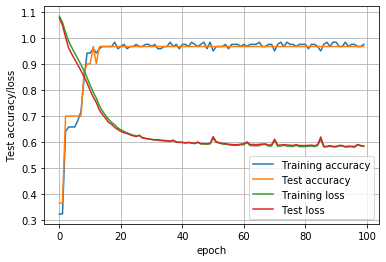

In [11]:
plt.plot(range(epochs), train_accuracy, label='Training accuracy')
plt.plot(range(epochs), test_accuracy, label='Test accuracy')
plt.plot(range(epochs), train_losses, label='Training loss')
plt.plot(range(epochs), test_losses, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('Test accuracy/loss')
plt.legend()
plt.grid()
plt.show()

## Confusion matrix

In [21]:
predicted = y_pred_cat.detach().numpy()
true = y_test_tensor.numpy()

np.set_printoptions(precision=2) # set NumPy to 2 decimal places
cnf_matrix = confusion_matrix(true, predicted)
cnf_matrix

array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  1, 10]])

### Plot confusion matrix

In [25]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print(cm)
    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[10  0  0]
 [ 0  9  0]
 [ 0  1 10]]



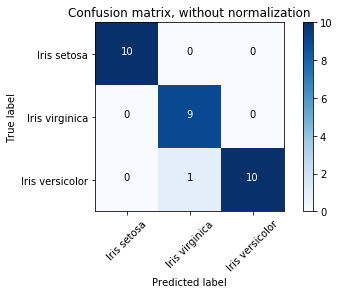

In [26]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')



Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.09090909 0.90909091]]



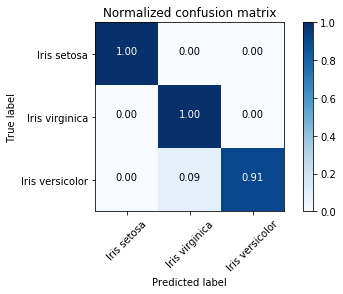

In [28]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

## Save a model

In [12]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

## Load a model

In [13]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))

<All keys matched successfully>

Apply the saved model to a new iris

In [14]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])
new_model.eval()
print(new_model(mystery_iris))
print(labels[new_model(mystery_iris).argmax()])

tensor([8.9230e-23, 1.0000e+00, 3.0587e-10], grad_fn=<SoftmaxBackward>)
Iris virginica
